# Exploratory Analysis of netCDF4 Data

This notebook aims to provide a basic understanding of netCDF4 files and their structure. Additionally, it visualizes the data contained within these files to gain insights into the key parameters and patterns they represent.

##  Outline
[0. Import Libraries](#import-libraries)<br>

[I. Observation Dataset](#observation-dataset)<br>
   &nbsp;&nbsp;&nbsp; [A. Load Data](#load-data)<br>
   &nbsp;&nbsp;&nbsp; [B. Column Information](#column-information)<br>
   &nbsp;&nbsp;&nbsp; [C. Time Variable Analysis](#time-variable-analysis)<br>
   &nbsp;&nbsp;&nbsp; [D. Geospatial Analysis: Latitude and Longitude Insights](#geospatial-analysis)<br>
   &nbsp;&nbsp;&nbsp; [E. Temperature Variable Analysis](#temperature-variable-analysis)<br>
   &nbsp;&nbsp;&nbsp; [F. Creation of Observation Dataframe](#creation-of-observation-dataframe)<br>
   &nbsp;&nbsp;&nbsp; [G. Close Data](#close-data)<br>

[II. Forecast Dataset](#forecast-dataset)<br>
   &nbsp;&nbsp;&nbsp; [A. Load Data](#forecast-load-data)<br>
   &nbsp;&nbsp;&nbsp; [B. Column Information](#forecast-column-information)<br>
   &nbsp;&nbsp;&nbsp; [C. Time Variable Analysis](#forecast-time-variable-analysis)<br>
   &nbsp;&nbsp;&nbsp; [D. Geospatial Analysis: Latitude and Longitude Insights](#forecast-geospatial-analysis)<br>
   &nbsp;&nbsp;&nbsp; [E. Temperature Variable Analysis](#forecast-temperature-variable-analysis)<br>
   &nbsp;&nbsp;&nbsp; [F. Creation of Forecast Dataframe](#creation-forecast-dataframe)<br>
   &nbsp;&nbsp;&nbsp; [G. Close Data](#close-data)<br>

[III. Combined Dataframe Forecast and Observed](#combined-dataframe-forecast-and-observed)<br>
   &nbsp;&nbsp;&nbsp; [A. Merge Dataframes](#merge-dataframes)<br>
   &nbsp;&nbsp;&nbsp; [B. Calculate RSME](#calculate-rsme)<br>
   &nbsp;&nbsp;&nbsp; [C. Visualizations](#visualizations)<br>
   &nbsp;&nbsp;&nbsp; [D. Save Results](#save-results)<br>




## Import libraries

In [1]:
import pandas as pd
import numpy as np
import netCDF4 as nc
from datetime import datetime, timedelta

## Observation Dataset

### Load Data

Read file observation

In [2]:
file_name = "../data/observation.nc"
observations = nc.Dataset(file_name, "r", format="NETCDF4")

### Column Information

There are 4 different columns. Time, Longitude, Latitude and Temperature

In [3]:
columns = observations.variables.keys()
columns

dict_keys(['time', 'lon', 'lat', 'temperatura'])

### Time Variable Analysis

In [4]:
observations.variables["time"][:10]

masked_array(data=[24., 25., 26., 27., 28., 29., 30., 31., 32., 33.],
             mask=False,
       fill_value=1e+20,
            dtype=float32)

In [5]:
observations.variables["time"][:10].data

array([24., 25., 26., 27., 28., 29., 30., 31., 32., 33.], dtype=float32)

According to documentation for the repo, the time of reference is 2018/04/14.

Also, time is hourly.

Starting time for the data is 2018-04-15 00:00:00

In [6]:
pd.Timedelta(hours=observations.variables["time"][:].data[0])+ pd.Timestamp("2018-04-14")

Timestamp('2018-04-15 00:00:00')

Ending time is '2018-04-17 23:00:00'

In [7]:
pd.Timedelta(hours=observations.variables["time"][:].data[-1])+ pd.Timestamp("2018-04-14")

Timestamp('2018-04-17 23:00:00')

Check if there are missing data times

In [8]:
len(observations.variables["time"][:].data[:]) == (observations.variables["time"][:].data[-1]-observations.variables["time"][:].data[0]+1)

True

In [9]:
num_hours = observations.variables["time"][:].data[:]
# change it to int
num_hours = [int(i) for i in num_hours]
num_hours[:10]

[24, 25, 26, 27, 28, 29, 30, 31, 32, 33]

Create a list of datetime values

In [10]:
start_date = "2018-04-14"
date_list = [datetime.strptime(start_date, '%Y-%m-%d') + timedelta(hours=i) for i in num_hours]
date_list[:2]

[datetime.datetime(2018, 4, 15, 0, 0), datetime.datetime(2018, 4, 15, 1, 0)]

### Geospatial Analysis

According to the information for the repo, SP corresponds to latitude is 8 and the longitude is 26. (Latitude -23.5489 e Longitude -46.6388)

In [11]:
observations.variables["lat"][8].data

array(-23.52493, dtype=float32)

In [12]:
observations.variables["lon"][26].data

array(-46.6783, dtype=float32)

### Temperature Variable Analysis

Check temperature for first hour. Temperature is in celsius but forecasted is in Kelvin. 

In [13]:
observations.variables["temperatura"][0].data[8, 26]

21.164131

In [14]:
y = []
for i in range(len(observations.variables["temperatura"])):
    y.append(observations.variables["temperatura"][i].data[8, 26])

In [15]:
y[:10]

[21.164131,
 20.641735,
 20.193924,
 20.087553,
 19.857996,
 19.709826,
 19.46206,
 19.19653,
 19.221806,
 19.103395]

#### Change units

Temperature is in celsius but forecasted is in Kelvin. 

In [16]:
def celsius_to_kelvin(celsius):
    """
    Convert temperature in Celsius to Kelvin.

    Parameters:
    celsius (float): Temperature in Celsius.

    Returns:
    float: Temperature in Kelvin.
    """
    kelvin = celsius + 273.15
    return kelvin

In [17]:
y_K = [celsius_to_kelvin(celsius) for celsius in y]

### Creation of Observation Dataframe

In [18]:
obs = pd.DataFrame(y_K, index=date_list, columns=["y"])

In [19]:
obs.head()

,y
2018-04-15 00:00:00,294.314131
2018-04-15 01:00:00,293.791735
2018-04-15 02:00:00,293.343924
2018-04-15 03:00:00,293.237553
2018-04-15 04:00:00,293.007996


In [20]:
obs.describe()

,y
count,72.000000
mean,292.838371
std,1.941994
min,290.094355
25%,291.722447
50%,292.554328
75%,293.379922
max,298.387343


### Close Data

In [21]:
observations.close()

## Forecast Dataset

### Load Data

Read file observation

In [22]:
file_name = "../data/forecast.nc"
forecast = nc.Dataset(file_name, "r", format="NETCDF4")

### Column Information

There are 4 different columns. Time, Longitude, Latitude and Temperature (t2m)
-> Observation and Forecast have different names for temperature

In [23]:
columns = forecast.variables.keys()
columns

dict_keys(['lat', 'lon', 'time', 't2m'])

### Time Variable Analysis

In [24]:
forecast.variables["time"][:10].data

array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.], dtype=float32)

According to documentation for the repo, the time of reference is 2018/04/14.

Also, time is hourly.

Starting time for the data is 2018-04-14 00:00:00

In [25]:
pd.Timedelta(hours=forecast.variables["time"][:].data[0])+ pd.Timestamp("2018-04-14")

Timestamp('2018-04-14 00:00:00')

Ending time is '2018-04-16 23:00:00'

In [26]:
pd.Timedelta(hours=forecast.variables["time"][:].data[-1])+ pd.Timestamp("2018-04-14")

Timestamp('2018-04-16 23:00:00')

Data from Observation and Forecast represent differ. Forecast starts a day earlier and ends a day earlier.

#### Check if there are missing data times

In [27]:
len(forecast.variables["time"][:].data[:]) == (forecast.variables["time"][:].data[-1]-forecast.variables["time"][:].data[0]+1)

True

In [28]:
num_hours = forecast.variables["time"][:].data[:]
# change it to int
num_hours = [int(i) for i in num_hours]
num_hours[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

#### Create a list of datetime values

In [29]:
start_date = "2018-04-14"
date_list = [datetime.strptime(start_date, '%Y-%m-%d') + timedelta(hours=i) for i in num_hours]
date_list[:2]

[datetime.datetime(2018, 4, 14, 0, 0), datetime.datetime(2018, 4, 14, 1, 0)]

### Geospatial Analysis

According to the information for the repo, SP corresponds to latitude is 8 and the longitude is 26. (Latitude -23.5489 e Longitude -46.6388)

In [30]:
forecast.variables["lat"][8].data

array(-23.524933, dtype=float32)

In [31]:
forecast.variables["lon"][26].data

array(-46.6783, dtype=float32)

### Temperature Variable Analysis

Check temperature for first hour. Temperature is in celsius but forecasted is in Kelvin. 

In [33]:
forecast.variables["t2m"][0].data[8,26]

/var/folders/41/c6rc607d4ns7r7h72ycqgkn00000gn/T/ipykernel_37723/382542684.py:1: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  forecast.variables["t2m"][0].data[8,26]


294.6625

In [34]:
y = []
for i in range(len(forecast.variables["t2m"])):
    y.append(forecast.variables["t2m"][i].data[8, 26])

/var/folders/41/c6rc607d4ns7r7h72ycqgkn00000gn/T/ipykernel_37723/1459715318.py:3: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
  y.append(forecast.variables["t2m"][i].data[8, 26])


In [35]:
y[:10]

[294.6625,
 293.97592,
 293.43875,
 293.16208,
 292.92062,
 292.68222,
 292.4611,
 292.28635,
 292.06927,
 291.84454]

### Creation of Observation Dataframe

In [36]:
pred = pd.DataFrame(y, index=date_list, columns=["pred"])

In [37]:
pred.head()

,pred
2018-04-14 00:00:00,294.662506
2018-04-14 01:00:00,293.975922
2018-04-14 02:00:00,293.438751
2018-04-14 03:00:00,293.162079
2018-04-14 04:00:00,292.920624


In [38]:
pred.describe()

,pred
count,72.000000
mean,292.744141
std,1.909311
min,290.449249
25%,291.426132
50%,292.215424
75%,293.363579
max,298.283081


### Close Data

In [39]:
observations.close()

## Combined Dataframe Forecast and Observed

### Merge Dataframes

In [43]:
df = pd.merge(obs, pred, left_index=True, right_index=True)
df.head()

,y,pred
2018-04-15 00:00:00,294.314131,291.942139
2018-04-15 01:00:00,293.791735,291.721344
2018-04-15 02:00:00,293.343924,291.556061
2018-04-15 03:00:00,293.237553,291.436493
2018-04-15 04:00:00,293.007996,291.353394


### Calculate RSME

In [46]:
def rsme(df):
    """
    Calculate the root mean squared error.

    Parameters:
    df (pandas.DataFrame): Dataframe with columns y and pred.

    Returns:
    float: Root mean squared error.
    """
    return np.sqrt(((df.y - df.pred) ** 2))

In [47]:
df["rsme"] = rsme(df)

In [48]:
df.head()

,y,pred,rsme
2018-04-15 00:00:00,294.314131,291.942139,2.371992
2018-04-15 01:00:00,293.791735,291.721344,2.070391
2018-04-15 02:00:00,293.343924,291.556061,1.787863
2018-04-15 03:00:00,293.237553,291.436493,1.801060
2018-04-15 04:00:00,293.007996,291.353394,1.654602


### Visualizations

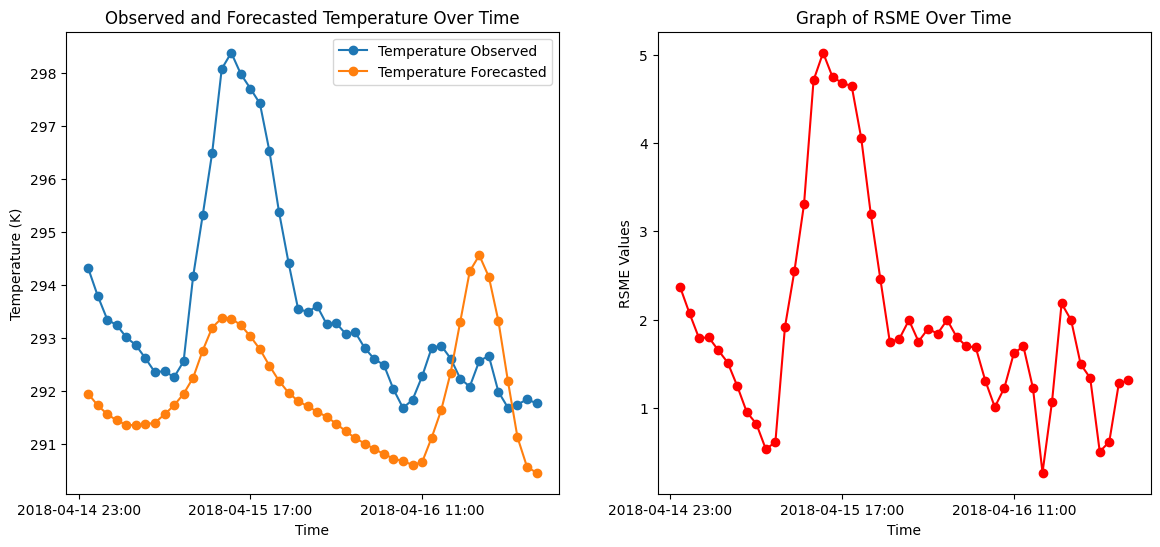

In [59]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.figure(figsize=(14, 6))

# Graph 1: Plotting the observed and forecasted values over time
plt.subplot(1, 2, 1)
plt.plot(df.index, df['y'], label='Temperature Observed', marker='o')
plt.plot(df.index, df['pred'], label='Temperature Forecasted', marker='o')
plt.xlabel('Time')
plt.ylabel('Temperature (K)')
plt.title('Observed and Forecasted Temperature Over Time')
plt.legend()

plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=18))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))



# Graph 2: RSME over time
plt.subplot(1, 2, 2)
plt.plot(df.index, df['rsme'], label='RSME', marker='o', color='r')
plt.xlabel('Time')
plt.ylabel('RSME Values')
plt.title('Graph of RSME Over Time')

plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=18))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))

plt.show()

Forecast is able to pick up on the trends but fails to predict the variance.

### Save Results

#### Modify datetime back to int

In [60]:
df.reset_index(inplace=True)
df.head()

,index,y,pred,rsme
0,2018-04-15 00:00:00,294.314131,291.942139,2.371992
1,2018-04-15 01:00:00,293.791735,291.721344,2.070391
2,2018-04-15 02:00:00,293.343924,291.556061,1.787863
3,2018-04-15 03:00:00,293.237553,291.436493,1.801060
4,2018-04-15 04:00:00,293.007996,291.353394,1.654602


In [61]:
column_names = ["time","temperatura","t2m","rsme"]
df.columns = column_names

In [62]:
reference_date = pd.to_datetime('2018-04-14 00:00:00')

In [63]:
df['time'] = (df['time'] - reference_date) / pd.Timedelta(hours=1)

# Convert to float
df['time'] = df['time'].astype(float)


In [64]:
df.head()

,time,temperatura,t2m,rsme
0,24.0,294.314131,291.942139,2.371992
1,25.0,293.791735,291.721344,2.070391
2,26.0,293.343924,291.556061,1.787863
3,27.0,293.237553,291.436493,1.801060
4,28.0,293.007996,291.353394,1.654602


#### Save results in output.nc file

In [65]:
file_path = "../data/output.nc"
dataset = nc.Dataset(file_path, 'w', format='NETCDF4')

for col in df.columns:
    dataset.createDimension(col, df[col].shape[0])

for col in df.columns:
    var = dataset.createVariable(col, df[col].dtype, (col,))
    var[:] = df[col].values